In [3]:
import torch
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser

In [4]:
new_dim = 256
finetuned_bert_path = "teacher-CoLA/pytorch_model.bin"
pretrained_bert_path = "{}/.cache/torch/pytorch_transformers/bert-large-uncased-pytorch_model.bin".format(expanduser("~"))
state_dict = torch.load(pretrained_bert_path, map_location=torch.device("cpu"))
embeddings_tensor = state_dict["bert.embeddings.word_embeddings.weight"]
embeddings = embeddings_tensor.numpy()
old_dim = embeddings.shape[1]

# Reproducing [Raunak (2017)](https://arxiv.org/pdf/1708.03629.pdf)

### Preprocessing

In [5]:
pca1 =  PCA(n_components=old_dim)
z = embeddings - np.mean(embeddings, axis=0)
pca1.fit(z)

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

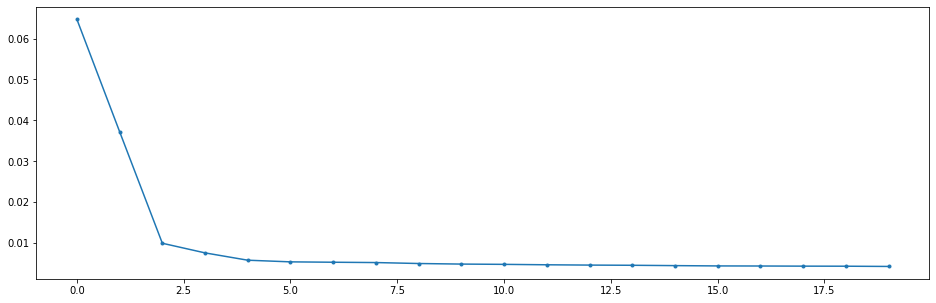

In [6]:
plt.figure(figsize=(16,5))
plt.plot(pca1.explained_variance_[:20], marker='.')
plt.show()

In [7]:
D1 = 5
U1 = pca1.components_
z1 = []
for i, x in enumerate(z):
    for u in U1[0:D1]:
        x = x - np.dot(u.T, x) * u 
    z1.append(x)
z1 = np.asarray(z1)

### Dimensionality reduction

In [9]:
pca2 =  PCA(n_components=new_dim)
z2 = z1 - np.mean(z1, axis=0)
z2 = pca2.fit_transform(z2)

### Postprocessing

In [11]:
pca3 = PCA(n_components=new_dim)
z3 = z2 - np.mean(z2, axis=0)
pca3.fit(z3)
U3 = pca3.components_

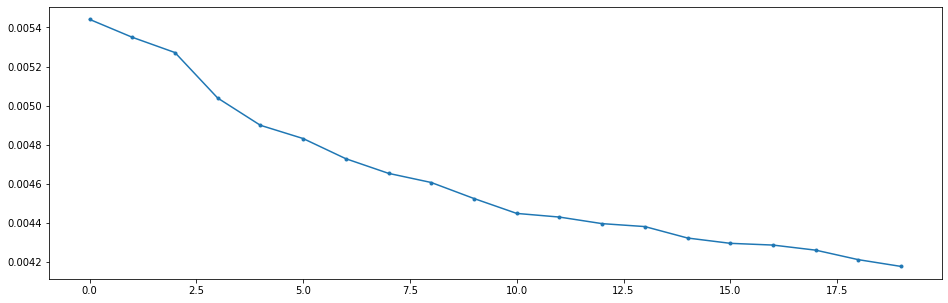

In [12]:
plt.figure(figsize=(16,5))
plt.plot(pca3.explained_variance_[:20], marker='.')
plt.show()

In [13]:
D3 = 0
if D3 > 0:
    U3 = pca3.components_
    z4 = []
    for i, x in enumerate(z3):
        for u in U3[0:D3]:
            x = x - np.dot(u.T, x) * u 
        z4.append(x)
    embeddings_new = np.asarray(z4)
else:
    embeddings_new = z3

In [16]:
torch.from_numpy(embeddings_new).float().to(torch.device("cpu"))

tensor([[ 0.0148,  0.0421,  0.0435,  ..., -0.0037,  0.0002,  0.0123],
        [ 0.0183,  0.0393,  0.0480,  ..., -0.0105,  0.0028,  0.0047],
        [ 0.0044,  0.0461,  0.0489,  ..., -0.0017,  0.0006,  0.0046],
        ...,
        [-0.0100,  0.0359,  0.0632,  ..., -0.0177,  0.0043, -0.0112],
        [-0.0100,  0.0618,  0.0534,  ...,  0.0155,  0.0125,  0.0028],
        [-0.0259, -0.0857,  0.0551,  ..., -0.0365, -0.0832,  0.0212]])